In [1]:
import copy
import adcc
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

au2ev = 27.211386

/Users/golo.dusanka/miniconda3/envs/echem/lib/python3.12/site-packages/adcc/misc.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

basis = "6-31G"
vlx_mol = vlx.Molecule.read_molecule_string(water_mol_str)
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(vlx_mol, vlx_bas)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -75.983870205310 a.u. Time: 0.05 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -76.384872592259    0.0000000000      0.05814060      0.01079184      0.00000000                


                  2       -76.384686594376    0.0001859979      0.07420221      0.01375784      0.03127402                


                  3       -76.385180742153   -0.0004941478      0.00038519      0.00008834      0.01650959                


                  4       -76.385180774173   -0.0000000320      0.00007657      0.00002027      0.00029092                


                  5       -76.385180774932   -0.0000000008      0.00000194      0.00000051      0.00002929                


                  6       -76.385180774934   -0.0000000000      0.00000014      0.00000003      0.00000214                


                                                                                                                          
               *** SCF converged in 6 iterations. Time: 0.16 sec.                                                         
                                                                                                                          


               Spin-Restricted Kohn-Sham:                                                                                 
               --------------------------                                                                                 
               Total Energy                       :      -76.3851807749 a.u.                                              
               Electronic Energy                  :      -85.5413254944 a.u.                                              
               Nuclear Repulsion Energy           :        9.1561447194 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000001389 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Z   :        -0.968145 a.u.        -2.460780 Debye                                     
                                 Total :         0.968145 a.u.         2.460780 Debye                                     
                

In [3]:
lr_eig_solver = vlx.LinearResponseEigenSolver()
lr_eig_solver.update_settings(scf_settings, method_settings)

lr_solver = vlx.LinearResponseSolver()
lr_solver.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lr_eig_solver.get_e2(vlx_mol, vlx_bas, scf_results)

# Property gradients for dipole operator
V1_x, V1_y, V1_z = lr_solver.get_prop_grad("electric dipole", "xyz", vlx_mol, vlx_bas, scf_results)

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2 * c)
S2[c : 2 * c, c : 2 * c] *= -1

* Info * Using the B3LYP functional.                                                                                      
                                                                                                                          
         P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
                                                                                                                          
* Info * Using the Libxc library (v7.0.0).                                                                                
                                                                                                                          
         S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
                                                                                                                          
* Info * Using the following algorithm for XC numer

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Processing 80 Fock builds...                                                                                     


In [4]:
# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2)  # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs) / 2)):
    j = i + int(len(eigs) / 2)  # focus on excitations
    Xf = X[:, j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x) ** 2 + np.dot(Xf, V1_y) ** 2 + np.dot(Xf, V1_z) ** 2
    fosc.append(tm * 2.0 / 3.0 * eigs[j])

In [5]:
lr_eig_solver.core_excitation = True
lr_eig_solver.num_core_orbitals = 1
lr_eig_solver.nstates = 3
vlx_cvs_results = lr_eig_solver.compute(vlx_mol, vlx_bas, scf_results)

                                                                                                                          
                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 3                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-06                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                

* Info * Using the B3LYP functional.                                                                                      
                                                                                                                          
         P. J. Stephens, F. J. Devlin, C. F. Chabalowski, and M. J. Frisch.,  J. Phys. Chem. 98, 11623 (1994)
                                                                                                                          
* Info * Using the Libxc library (v7.0.0).                                                                                
                                                                                                                          
         S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
                                                                                                                          
* Info * Using the following algorithm for XC numer

* Info * Molecular grid with 40792 points generated in 0.03 sec.                                                          
                                                                                                                          
* Info * Processing 3 Fock builds...                                                                                      


                                                                                                                          
* Info * 3 gerade trial vectors in reduced space                                                                          
* Info * 3 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 1.75 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.37 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   1 * Residuals (Max,Min): 9.82e-02 and 2.73e-02                                            
                

* Info * Processing 2 Fock builds...                                                                                      


                                                                                                                          
* Info * 5 gerade trial vectors in reduced space                                                                          
* Info * 5 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 2.42 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.37 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   2 * Residuals (Max,Min): 1.01e-02 and 4.04e-14                                            
                

* Info * Processing 1 Fock build...                                                                                       


                                                                                                                          
* Info * 6 gerade trial vectors in reduced space                                                                          
* Info * 6 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 2.68 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.37 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   3 * Residuals (Max,Min): 2.51e-04 and 3.92e-14                                            
                

* Info * Processing 1 Fock build...                                                                                       


                                                                                                                          
* Info * 7 gerade trial vectors in reduced space                                                                          
* Info * 7 ungerade trial vectors in reduced space                                                                        
                                                                                                                          
* Info * 2.77 kB of memory used for subspace procedure on the master node                                                 
* Info * 2.37 GB of memory available for the solver on the master node                                                    
                                                                                                                          
               *** Iteration:   4 * Residuals (Max,Min): 6.05e-14 and 1.60e-14                                            
                

               *** Linear response converged in 4 iterations. Time: 0.23 sec                                              
                                                                                                                          
                                                                                                                          


               Electric Transition Dipole Moments (dipole length, a.u.)                                                   
               --------------------------------------------------------                                                   
                                                X            Y            Z                                               
               Excited State    S1:      0.000000    -0.000000    -0.036994                                               
               Excited State    S2:     -0.053332     0.000000    -0.000000                                               
               Excited State    S3:     -0.026326     0.000000     0.000000                                               
                                                                                                                          


               Electric Transition Dipole Moments (dipole velocity, a.u.)                                                 
               ----------------------------------------------------------                                                 
                                                X            Y            Z                                               
               Excited State    S1:      0.000000    -0.000000    -0.037908                                               
               Excited State    S2:     -0.054574     0.000000    -0.000000                                               
               Excited State    S3:     -0.023365     0.000000     0.000000                                               
                                                                                                                          


               Magnetic Transition Dipole Moments (a.u.)                                                                  
               -----------------------------------------                                                                  
                                                X            Y            Z                                               
               Excited State    S1:      0.000000     0.000000     0.000000                                               
               Excited State    S2:     -0.000000    -0.116020    -0.000000                                               
               Excited State    S3:     -0.000000    -0.051026    -0.000000                                               
                                                                                                                          


               One-Photon Absorption                                                                                      
               ---------------------                                                                                      
               Excited State    S1:     19.11231840 a.u.    520.07268 eV    Osc.Str.    0.0174                            
               Excited State    S2:     19.18487023 a.u.    522.04691 eV    Osc.Str.    0.0364                            
               Excited State    S3:     19.84589976 a.u.    540.03444 eV    Osc.Str.    0.0092                            
                                                                                                                          


               Electronic Circular Dichroism                                                                              
               -----------------------------                                                                              
               Excited State    S1:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S2:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
               Excited State    S3:     Rot.Str.      0.000000 a.u.     0.0000 [10**(-40) cgs]                            
                                                                                                                          


               Character of excitations:                                                                                  
                                                                                                                          
               Excited state 1                                                                                            
               ---------------                                                                                            
               core_1   -> LUMO        -0.9993                                                                            
                                                                                                                          
               Excited state 2                                                                                            
               ---------------                                                                                            
               c

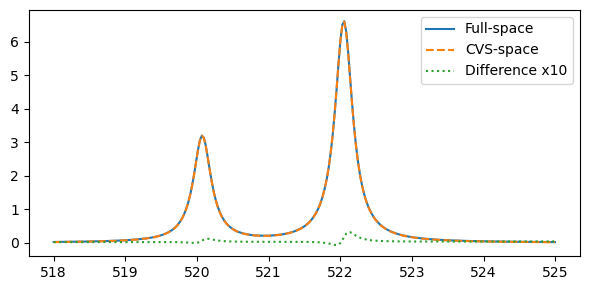

In [6]:
plt.figure(figsize=(6,3))

x, y = eigs[int(len(eigs) / 2) :], fosc
x1, y1 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x1 * au2ev, y1)

x, y = vlx_cvs_results['eigenvalues'], vlx_cvs_results['oscillator_strengths']
x2, y2 = lorentzian(x, y, 518 / au2ev, 525 / au2ev, 0.001, 0.3 / au2ev)
plt.plot(x2 * au2ev, y2, linestyle='--')

plt.plot(x1 * au2ev, 10*(y1 - y2), linestyle=':')

plt.legend(("Full-space", "CVS-space", "Difference x10"))
plt.tight_layout()
plt.show()